<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/CODE4_85p51_STEPLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#chsum = 0
##pbar = tqdm(train_loader_nonorm)

#for index, (data,target) in enumerate(train_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(train_nonorm) * 32 *32)
#
#chsum = None
#for index, (data,target) in enumerate(train_loader_nonorm):
#  if index == 0:
#   print(data.min(),data.max())
#   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
#print("Traindata Mean",mean)
#print("Traindata std dev",std)

#chsum = 0

#for index, (data,target) in enumerate(test_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(test_nonorm) * 32 *32)

#chsum = None
#for index, (data,target) in enumerate(test_loader_nonorm):
#  if index == 0:
#    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
#print("Test data Mean",mean)
#print("Test data std dev",std)

ship


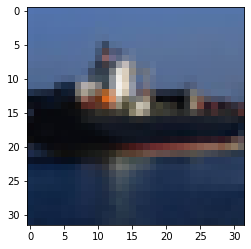

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [12]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32 ; #Receptive field = 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 5x5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 7x7

        #self.convblock16 = nn.Sequential(
        #    nn.Conv2d(in_channels=64, out_channels=128, groups=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False),
        #    nn.BatchNorm2d(128),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc)
        #) # output_size = 32; #Receptive field = 7x7


        #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32; #Receptive field = 7x7

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation =1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling
        #self.pool1 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #   nn.Dropout(dropout_perc)
        #    #nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        #)
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        #BLOCK C3
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #BLOCK C4
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=256, groups = 256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False)
        ) # output_size = 8; #Receptive field = 5x5

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(512,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        #x = self.convblock16(x)
        x = self.convblock4(x)
        
        x = self.pool1(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.pool2(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = self.pool3(x)
        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [13]:
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [14]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [15]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=12, gamma=0.7)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    scheduler.step()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

Loss=2.2530109882354736 Batch_id=390 Accuracy=36.69: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 14405.0196, Accuracy: 4708/10000 (47.08%)

EPOCH: 1
Epoch 1, lr 0.02


Loss=1.8025612831115723 Batch_id=390 Accuracy=49.90: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 12390.8891, Accuracy: 5549/10000 (55.49%)

EPOCH: 2
Epoch 2, lr 0.02


Loss=1.6279542446136475 Batch_id=390 Accuracy=54.72: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9881.3446, Accuracy: 6433/10000 (64.33%)

EPOCH: 3
Epoch 3, lr 0.02


Loss=1.5290027856826782 Batch_id=390 Accuracy=57.74: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9199.6495, Accuracy: 6765/10000 (67.65%)

EPOCH: 4
Epoch 4, lr 0.02


Loss=1.7208527326583862 Batch_id=390 Accuracy=59.57: 100%|██████████| 391/391 [00:16<00:00, 23.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9122.0504, Accuracy: 6759/10000 (67.59%)

EPOCH: 5
Epoch 5, lr 0.02


Loss=1.5036637783050537 Batch_id=390 Accuracy=60.97: 100%|██████████| 391/391 [00:16<00:00, 23.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8765.8938, Accuracy: 6960/10000 (69.60%)

EPOCH: 6
Epoch 6, lr 0.02


Loss=1.576328992843628 Batch_id=390 Accuracy=62.25: 100%|██████████| 391/391 [00:16<00:00, 23.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8248.7751, Accuracy: 7097/10000 (70.97%)

EPOCH: 7
Epoch 7, lr 0.02


Loss=1.6507227420806885 Batch_id=390 Accuracy=62.85: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8009.9519, Accuracy: 7207/10000 (72.07%)

EPOCH: 8
Epoch 8, lr 0.02


Loss=1.6010286808013916 Batch_id=390 Accuracy=63.96: 100%|██████████| 391/391 [00:16<00:00, 23.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7995.3429, Accuracy: 7156/10000 (71.56%)

EPOCH: 9
Epoch 9, lr 0.02


Loss=1.5958921909332275 Batch_id=390 Accuracy=64.20: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8069.2403, Accuracy: 7201/10000 (72.01%)

EPOCH: 10
Epoch 10, lr 0.02


Loss=1.6354460716247559 Batch_id=390 Accuracy=65.21: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7713.4588, Accuracy: 7301/10000 (73.01%)

EPOCH: 11
Epoch 11, lr 0.013999999999999999


Loss=1.671903371810913 Batch_id=390 Accuracy=66.78: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7307.4519, Accuracy: 7424/10000 (74.24%)

EPOCH: 12
Epoch 12, lr 0.013999999999999999


Loss=1.6038743257522583 Batch_id=390 Accuracy=66.85: 100%|██████████| 391/391 [00:16<00:00, 23.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7462.0127, Accuracy: 7362/10000 (73.62%)

EPOCH: 13
Epoch 13, lr 0.013999999999999999


Loss=1.4377338886260986 Batch_id=390 Accuracy=67.46: 100%|██████████| 391/391 [00:16<00:00, 23.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6859.4029, Accuracy: 7627/10000 (76.27%)

EPOCH: 14
Epoch 14, lr 0.013999999999999999


Loss=1.3453867435455322 Batch_id=390 Accuracy=67.23: 100%|██████████| 391/391 [00:16<00:00, 23.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6813.2383, Accuracy: 7653/10000 (76.53%)

EPOCH: 15
Epoch 15, lr 0.013999999999999999


Loss=1.3649379014968872 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [00:16<00:00, 23.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6453.4995, Accuracy: 7734/10000 (77.34%)

EPOCH: 16
Epoch 16, lr 0.013999999999999999


Loss=1.5092250108718872 Batch_id=390 Accuracy=67.67: 100%|██████████| 391/391 [00:16<00:00, 23.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6862.4513, Accuracy: 7586/10000 (75.86%)

EPOCH: 17
Epoch 17, lr 0.013999999999999999


Loss=1.4886616468429565 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6705.4628, Accuracy: 7638/10000 (76.38%)

EPOCH: 18
Epoch 18, lr 0.013999999999999999


Loss=1.3645241260528564 Batch_id=390 Accuracy=68.39: 100%|██████████| 391/391 [00:16<00:00, 23.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6372.8199, Accuracy: 7833/10000 (78.33%)

EPOCH: 19
Epoch 19, lr 0.013999999999999999


Loss=1.5830047130584717 Batch_id=390 Accuracy=68.73: 100%|██████████| 391/391 [00:16<00:00, 23.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6682.9271, Accuracy: 7614/10000 (76.14%)

EPOCH: 20
Epoch 20, lr 0.013999999999999999


Loss=1.2696492671966553 Batch_id=390 Accuracy=68.58: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6400.4672, Accuracy: 7780/10000 (77.80%)

EPOCH: 21
Epoch 21, lr 0.013999999999999999


Loss=1.287511944770813 Batch_id=390 Accuracy=69.07: 100%|██████████| 391/391 [00:16<00:00, 23.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6692.5978, Accuracy: 7686/10000 (76.86%)

EPOCH: 22
Epoch 22, lr 0.013999999999999999


Loss=1.3730723857879639 Batch_id=390 Accuracy=69.30: 100%|██████████| 391/391 [00:16<00:00, 23.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6097.6276, Accuracy: 7907/10000 (79.07%)

EPOCH: 23
Epoch 23, lr 0.009799999999999998


Loss=1.1695590019226074 Batch_id=390 Accuracy=70.74: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5968.5087, Accuracy: 7923/10000 (79.23%)

EPOCH: 24
Epoch 24, lr 0.009799999999999998


Loss=1.3719027042388916 Batch_id=390 Accuracy=70.67: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5809.6292, Accuracy: 7966/10000 (79.66%)

EPOCH: 25
Epoch 25, lr 0.009799999999999998


Loss=1.3342558145523071 Batch_id=390 Accuracy=71.05: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5776.2957, Accuracy: 8008/10000 (80.08%)

EPOCH: 26
Epoch 26, lr 0.009799999999999998


Loss=1.183060646057129 Batch_id=390 Accuracy=70.67: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5855.0015, Accuracy: 7962/10000 (79.62%)

EPOCH: 27
Epoch 27, lr 0.009799999999999998


Loss=1.380232334136963 Batch_id=390 Accuracy=70.92: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6043.7146, Accuracy: 7881/10000 (78.81%)

EPOCH: 28
Epoch 28, lr 0.009799999999999998


Loss=1.4965626001358032 Batch_id=390 Accuracy=70.96: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5887.7581, Accuracy: 8010/10000 (80.10%)

EPOCH: 29
Epoch 29, lr 0.009799999999999998


Loss=1.1537950038909912 Batch_id=390 Accuracy=70.91: 100%|██████████| 391/391 [00:17<00:00, 22.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6045.6225, Accuracy: 7924/10000 (79.24%)

EPOCH: 30
Epoch 30, lr 0.009799999999999998


Loss=1.3624999523162842 Batch_id=390 Accuracy=71.14: 100%|██████████| 391/391 [00:16<00:00, 23.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5837.7603, Accuracy: 7985/10000 (79.85%)

EPOCH: 31
Epoch 31, lr 0.009799999999999998


Loss=1.2055729627609253 Batch_id=390 Accuracy=71.23: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5634.1020, Accuracy: 8077/10000 (80.77%)

EPOCH: 32
Epoch 32, lr 0.009799999999999998


Loss=1.2154619693756104 Batch_id=390 Accuracy=71.31: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5792.7012, Accuracy: 8003/10000 (80.03%)

EPOCH: 33
Epoch 33, lr 0.009799999999999998


Loss=1.4587948322296143 Batch_id=390 Accuracy=71.65: 100%|██████████| 391/391 [00:16<00:00, 23.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5895.5948, Accuracy: 7980/10000 (79.80%)

EPOCH: 34
Epoch 34, lr 0.009799999999999998


Loss=1.255325198173523 Batch_id=390 Accuracy=71.38: 100%|██████████| 391/391 [00:17<00:00, 22.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5590.1720, Accuracy: 8064/10000 (80.64%)

EPOCH: 35
Epoch 35, lr 0.006859999999999998


Loss=1.2409454584121704 Batch_id=390 Accuracy=72.84: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5421.2055, Accuracy: 8103/10000 (81.03%)

EPOCH: 36
Epoch 36, lr 0.006859999999999998


Loss=1.130313515663147 Batch_id=390 Accuracy=72.69: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5593.1398, Accuracy: 8086/10000 (80.86%)

EPOCH: 37
Epoch 37, lr 0.006859999999999998


Loss=1.246206283569336 Batch_id=390 Accuracy=73.12: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5465.4802, Accuracy: 8150/10000 (81.50%)

EPOCH: 38
Epoch 38, lr 0.006859999999999998


Loss=1.225233793258667 Batch_id=390 Accuracy=73.05: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5447.1404, Accuracy: 8165/10000 (81.65%)

EPOCH: 39
Epoch 39, lr 0.006859999999999998


Loss=1.2019414901733398 Batch_id=390 Accuracy=73.00: 100%|██████████| 391/391 [00:16<00:00, 23.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5346.5514, Accuracy: 8151/10000 (81.51%)

EPOCH: 40
Epoch 40, lr 0.006859999999999998


Loss=1.2193467617034912 Batch_id=390 Accuracy=73.01: 100%|██████████| 391/391 [00:16<00:00, 23.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5330.6979, Accuracy: 8187/10000 (81.87%)

EPOCH: 41
Epoch 41, lr 0.006859999999999998


Loss=1.3629907369613647 Batch_id=390 Accuracy=72.82: 100%|██████████| 391/391 [00:17<00:00, 22.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5337.9181, Accuracy: 8144/10000 (81.44%)

EPOCH: 42
Epoch 42, lr 0.006859999999999998


Loss=1.1707968711853027 Batch_id=390 Accuracy=73.19: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5388.6411, Accuracy: 8128/10000 (81.28%)

EPOCH: 43
Epoch 43, lr 0.006859999999999998


Loss=1.3261668682098389 Batch_id=390 Accuracy=72.84: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5356.2606, Accuracy: 8167/10000 (81.67%)

EPOCH: 44
Epoch 44, lr 0.006859999999999998


Loss=1.2991600036621094 Batch_id=390 Accuracy=73.10: 100%|██████████| 391/391 [00:17<00:00, 22.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5188.5448, Accuracy: 8200/10000 (82.00%)

EPOCH: 45
Epoch 45, lr 0.006859999999999998


Loss=1.1810287237167358 Batch_id=390 Accuracy=73.42: 100%|██████████| 391/391 [00:17<00:00, 22.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5232.7054, Accuracy: 8200/10000 (82.00%)

EPOCH: 46
Epoch 46, lr 0.006859999999999998


Loss=1.212342619895935 Batch_id=390 Accuracy=72.91: 100%|██████████| 391/391 [00:16<00:00, 23.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4945.2380, Accuracy: 8310/10000 (83.10%)

EPOCH: 47
Epoch 47, lr 0.004801999999999998


Loss=1.280045747756958 Batch_id=390 Accuracy=74.17: 100%|██████████| 391/391 [00:17<00:00, 22.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4970.3403, Accuracy: 8320/10000 (83.20%)

EPOCH: 48
Epoch 48, lr 0.004801999999999998


Loss=1.1389650106430054 Batch_id=390 Accuracy=74.57: 100%|██████████| 391/391 [00:17<00:00, 22.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4997.0314, Accuracy: 8309/10000 (83.09%)

EPOCH: 49
Epoch 49, lr 0.004801999999999998


Loss=1.2034283876419067 Batch_id=390 Accuracy=74.43: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4863.5535, Accuracy: 8317/10000 (83.17%)

EPOCH: 50
Epoch 50, lr 0.004801999999999998


Loss=1.0893619060516357 Batch_id=390 Accuracy=74.53: 100%|██████████| 391/391 [00:17<00:00, 22.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4991.3694, Accuracy: 8256/10000 (82.56%)

EPOCH: 51
Epoch 51, lr 0.004801999999999998


Loss=1.097023367881775 Batch_id=390 Accuracy=74.60: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5045.8551, Accuracy: 8283/10000 (82.83%)

EPOCH: 52
Epoch 52, lr 0.004801999999999998


Loss=1.3123687505722046 Batch_id=390 Accuracy=74.82: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4894.1251, Accuracy: 8358/10000 (83.58%)

EPOCH: 53
Epoch 53, lr 0.004801999999999998


Loss=1.059085726737976 Batch_id=390 Accuracy=74.23: 100%|██████████| 391/391 [00:17<00:00, 22.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4910.4457, Accuracy: 8331/10000 (83.31%)

EPOCH: 54
Epoch 54, lr 0.004801999999999998


Loss=1.174052357673645 Batch_id=390 Accuracy=74.41: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4971.4602, Accuracy: 8259/10000 (82.59%)

EPOCH: 55
Epoch 55, lr 0.004801999999999998


Loss=1.147124171257019 Batch_id=390 Accuracy=74.80: 100%|██████████| 391/391 [00:17<00:00, 22.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4892.7306, Accuracy: 8303/10000 (83.03%)

EPOCH: 56
Epoch 56, lr 0.004801999999999998


Loss=1.3079627752304077 Batch_id=390 Accuracy=74.51: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4954.3893, Accuracy: 8285/10000 (82.85%)

EPOCH: 57
Epoch 57, lr 0.004801999999999998


Loss=1.0869314670562744 Batch_id=390 Accuracy=74.68: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4884.5289, Accuracy: 8353/10000 (83.53%)

EPOCH: 58
Epoch 58, lr 0.004801999999999998


Loss=1.267126202583313 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4850.4127, Accuracy: 8324/10000 (83.24%)

EPOCH: 59
Epoch 59, lr 0.0033613999999999983


Loss=1.1222776174545288 Batch_id=390 Accuracy=75.36: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4663.9188, Accuracy: 8417/10000 (84.17%)

EPOCH: 60
Epoch 60, lr 0.0033613999999999983


Loss=1.152294397354126 Batch_id=390 Accuracy=75.41: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4682.0511, Accuracy: 8361/10000 (83.61%)

EPOCH: 61
Epoch 61, lr 0.0033613999999999983


Loss=1.3455721139907837 Batch_id=390 Accuracy=75.68: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4742.9020, Accuracy: 8411/10000 (84.11%)

EPOCH: 62
Epoch 62, lr 0.0033613999999999983


Loss=0.9952552318572998 Batch_id=390 Accuracy=75.32: 100%|██████████| 391/391 [00:17<00:00, 22.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4726.4555, Accuracy: 8429/10000 (84.29%)

EPOCH: 63
Epoch 63, lr 0.0033613999999999983


Loss=1.001263976097107 Batch_id=390 Accuracy=75.73: 100%|██████████| 391/391 [00:17<00:00, 22.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4793.6128, Accuracy: 8373/10000 (83.73%)

EPOCH: 64
Epoch 64, lr 0.0033613999999999983


Loss=0.929845929145813 Batch_id=390 Accuracy=75.30: 100%|██████████| 391/391 [00:17<00:00, 22.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4692.9976, Accuracy: 8410/10000 (84.10%)

EPOCH: 65
Epoch 65, lr 0.0033613999999999983


Loss=1.220813512802124 Batch_id=390 Accuracy=75.59: 100%|██████████| 391/391 [00:17<00:00, 22.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4677.3329, Accuracy: 8409/10000 (84.09%)

EPOCH: 66
Epoch 66, lr 0.0033613999999999983


Loss=1.109529733657837 Batch_id=390 Accuracy=75.80: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5087.7667, Accuracy: 8260/10000 (82.60%)

EPOCH: 67
Epoch 67, lr 0.0033613999999999983


Loss=1.0797826051712036 Batch_id=390 Accuracy=75.59: 100%|██████████| 391/391 [00:17<00:00, 22.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4661.8252, Accuracy: 8440/10000 (84.40%)

EPOCH: 68
Epoch 68, lr 0.0033613999999999983


Loss=1.0234856605529785 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:17<00:00, 22.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4442.2393, Accuracy: 8500/10000 (85.00%)

EPOCH: 69
Epoch 69, lr 0.0033613999999999983


Loss=0.9205815196037292 Batch_id=390 Accuracy=75.54: 100%|██████████| 391/391 [00:16<00:00, 23.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4637.0440, Accuracy: 8388/10000 (83.88%)

EPOCH: 70
Epoch 70, lr 0.0033613999999999983


Loss=1.0256733894348145 Batch_id=390 Accuracy=75.58: 100%|██████████| 391/391 [00:17<00:00, 22.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4647.1470, Accuracy: 8424/10000 (84.24%)

EPOCH: 71
Epoch 71, lr 0.002352979999999999


Loss=1.0112407207489014 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:17<00:00, 23.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4454.8049, Accuracy: 8475/10000 (84.75%)

EPOCH: 72
Epoch 72, lr 0.002352979999999999


Loss=1.1150636672973633 Batch_id=390 Accuracy=76.40: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4594.0785, Accuracy: 8407/10000 (84.07%)

EPOCH: 73
Epoch 73, lr 0.002352979999999999


Loss=0.9947691559791565 Batch_id=390 Accuracy=76.48: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4555.8109, Accuracy: 8450/10000 (84.50%)

EPOCH: 74
Epoch 74, lr 0.002352979999999999


Loss=1.043358325958252 Batch_id=390 Accuracy=76.63: 100%|██████████| 391/391 [00:16<00:00, 23.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4392.2268, Accuracy: 8538/10000 (85.38%)

EPOCH: 75
Epoch 75, lr 0.002352979999999999


Loss=0.9694857597351074 Batch_id=390 Accuracy=76.59: 100%|██████████| 391/391 [00:17<00:00, 22.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4434.9269, Accuracy: 8489/10000 (84.89%)

EPOCH: 76
Epoch 76, lr 0.002352979999999999


Loss=1.0293444395065308 Batch_id=390 Accuracy=76.51: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4429.9317, Accuracy: 8507/10000 (85.07%)

EPOCH: 77
Epoch 77, lr 0.002352979999999999


Loss=0.9616476893424988 Batch_id=390 Accuracy=76.88: 100%|██████████| 391/391 [00:17<00:00, 22.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4595.7614, Accuracy: 8410/10000 (84.10%)

EPOCH: 78
Epoch 78, lr 0.002352979999999999


Loss=1.1011247634887695 Batch_id=390 Accuracy=76.89: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4482.7555, Accuracy: 8467/10000 (84.67%)

EPOCH: 79
Epoch 79, lr 0.002352979999999999


Loss=1.008457899093628 Batch_id=390 Accuracy=76.86: 100%|██████████| 391/391 [00:17<00:00, 22.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4464.3364, Accuracy: 8473/10000 (84.73%)

EPOCH: 80
Epoch 80, lr 0.002352979999999999


Loss=1.2679791450500488 Batch_id=390 Accuracy=76.83: 100%|██████████| 391/391 [00:17<00:00, 22.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4546.1234, Accuracy: 8445/10000 (84.45%)

EPOCH: 81
Epoch 81, lr 0.002352979999999999


Loss=1.0390464067459106 Batch_id=390 Accuracy=76.54: 100%|██████████| 391/391 [00:17<00:00, 22.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4469.7945, Accuracy: 8464/10000 (84.64%)

EPOCH: 82
Epoch 82, lr 0.002352979999999999


Loss=1.2444874048233032 Batch_id=390 Accuracy=76.95: 100%|██████████| 391/391 [00:17<00:00, 22.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4410.8315, Accuracy: 8466/10000 (84.66%)

EPOCH: 83
Epoch 83, lr 0.0016470859999999992


Loss=0.9748275279998779 Batch_id=390 Accuracy=77.14: 100%|██████████| 391/391 [00:17<00:00, 22.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4223.8871, Accuracy: 8551/10000 (85.51%)

EPOCH: 84
Epoch 84, lr 0.0016470859999999992


Loss=1.1135382652282715 Batch_id=390 Accuracy=77.59: 100%|██████████| 391/391 [00:17<00:00, 22.73it/s]



Test set: Average loss: 4416.1089, Accuracy: 8503/10000 (85.03%)

Actual Labels
horse  deer   cat  deer truck  bird  deer plane plane truck
Predicted Labels
  cat  bird plane  bird  ship plane  ship  ship horse   car


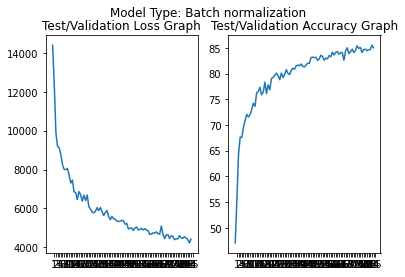

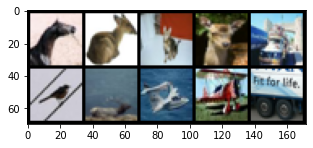

In [16]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,85)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


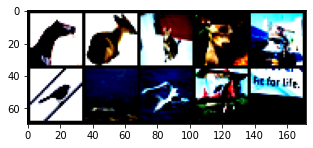

In [17]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

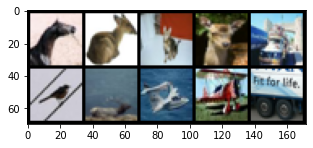

In [18]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
